<a href="https://colab.research.google.com/github/PSergey24/jupyter_notebooks/blob/main/NBA_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree

In [ ]:
# franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 8: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 35: 'Denver Nuggets', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}

In [2]:
franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 35: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}
def get_key(value):
    for k, v in franchises.items():
        if v == value:
            return k

def name_to_id(name):
  return get_key(name)

In [3]:
def union_data(df, df_odds):
  new_df = pd.merge(df, df_odds[['home_odd', 'visitor_odd', 'id_home', 'id_visitor', 'home_score','visitor_score']],  how='inner', left_on=['id_home', 'id_visitor', 'home_score','visitor_score'], right_on = ['id_home', 'id_visitor', 'home_score','visitor_score'])
  return new_df


In [4]:
def union_data_2(df_input):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_input['visitor_odd'] = 'empty'
  df_input['home_odd'] = 'empty' 
  for i, row in df_input.iterrows():
      # print(df_input.loc[i, :])
      info_odds = odds[(odds['id_home'] == df_input.loc[i, :]['id_home']) & (odds['id_visitor'] == df_input.loc[i, :]['id_visitor']) & (odds['home_score'] == df_input.loc[i, :]['home_score']) & (odds['visitor_score'] == df_input.loc[i, :]['visitor_score'])]
      if len(info_odds) != 1:
        continue
      df_input.at[i, 'visitor_odd'] = float(info_odds.visitor_odd)
      df_input.at[i, 'home_odd'] = float(info_odds.home_odd)
  return df_input

In [5]:
# months = {'jan': 1, 'feb': 2, 'mar': 3,  'nov': 11, 'dec': 12}
def get_month(date):
  month = date.split(',')[1].strip().split(' ')[0].strip().lower()
  return month

In [6]:
df_all = pd.read_csv('drive/MyDrive/Colab Notebooks/data/dataset_9_6_2022.csv', sep=',')
odds = pd.read_csv('drive/MyDrive/Colab Notebooks/data/odds.csv', sep='\t', index_col = [0])

df_all.rename({'pts_visitor': 'visitor_score', 'pts_home': 'home_score'}, axis=1, inplace=True)
df = df_all[(df_all['season'] > 2000) & (df_all['season'] < 2017)]
df_validate = df_all[df_all['season'] > 2016]

In [8]:
df = df[df[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
df_validate = df_validate[df_validate[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
df_validate['month'] = df_validate['date'].apply(get_month)
odds = odds.loc[(odds['home_odd'] != '-') & (odds['visitor_odd'] != '-')]
odds = odds.astype({"visitor_score": "Int64", "home_score": "Int64", "home_odd": "float32", "visitor_odd": "float32"})

In [9]:
odds['id_home'] = odds['home'].apply(lambda x: name_to_id(x))
odds['id_visitor'] = odds['visitor'].apply(lambda x: name_to_id(x))

In [10]:
odds.head(3)

,season,date,time,home,visitor,home_score,visitor_score,home_odd,visitor_odd,info,id_home,id_visitor
0,2017,12 Jun 2017,21:00,Golden State Warriors,Cleveland Cavaliers,129,120,1.26,4.19,NaN,10,6
1,2017,09 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,137,116,2.67,1.52,NaN,6,10
2,2017,07 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,113,118,2.39,1.64,NaN,6,10


In [11]:
df_validate.head(3)

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,month
32344,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.574,0.483,0.470,0.386,0.344,0.266,0,0,1,oct
32348,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.515,0.404,0.320,0.265,0.224,0.211,0,0,1,oct
32349,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.463,0.413,0.403,0.389,0.359,0.246,0,1,1,oct


In [12]:
df_full_validate = union_data_2(df_validate)

In [13]:
df_full_validate = df_full_validate[(df_full_validate['visitor_odd'] != 'empty') | (df_full_validate['home_odd'] != 'empty')]
df_full_validate

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,month,visitor_odd,home_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.470,0.386,0.344,0.266,0,0,1,oct,2.36,1.69
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.320,0.265,0.224,0.211,0,0,1,oct,1.74,2.21
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.403,0.389,0.359,0.246,0,1,1,oct,1.27,4.04
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.233,0.212,0.175,0.121,0,0,1,oct,1.62,2.36
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.361,0.336,0.292,0.237,0,0,0,oct,1.45,3.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.463,0.358,0.344,0.333,0,0,0,may,3.26,1.37
7429,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.409,0.406,0.327,0.318,0,0,1,may,4.17,1.26
7430,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.272,0.204,0.195,0.161,0,0,1,may,1.68,2.27
7431,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,0.987,0.522,0.471,0.470,0,0,1,jun,2.43,1.61


In [14]:
df_full_validate_2 = union_data(df_validate, odds)
df_full_validate_2

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,month,home_odd,visitor_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.470,0.386,0.344,0.266,0,0,1,oct,1.69,2.36
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.320,0.265,0.224,0.211,0,0,1,oct,2.21,1.74
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.403,0.389,0.359,0.246,0,1,1,oct,4.04,1.27
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.233,0.212,0.175,0.121,0,0,1,oct,2.36,1.62
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.361,0.336,0.292,0.237,0,0,0,oct,3.01,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.463,0.358,0.344,0.333,0,0,0,may,1.37,3.26
7436,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.409,0.406,0.327,0.318,0,0,1,may,1.26,4.17
7437,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.272,0.204,0.195,0.161,0,0,1,may,2.27,1.68
7438,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,0.987,0.522,0.471,0.470,0,0,1,jun,1.61,2.43


In [15]:
df = df.loc[:, 'ELO_visitor':]
train_df, test_df = train_test_split(df, test_size=2000)

In [16]:
train_df.head(3)

,ELO_visitor,ELO_home,t1p0_per,t1p1_per,t1p2_per,t1p3_per,t1p4_per,t1p5_per,t1p6_per,t1p7_per,...,t2p1_per,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y
16891,0.369,0.177,0.366,0.301,0.226,0.177,0.156,0.095,0.092,0.089,...,0.506,0.471,0.467,0.361,0.338,0.261,0.230,0,0,0
19022,0.096,-0.205,1.000,1.000,0.602,0.513,0.436,0.401,0.378,0.296,...,0.448,0.419,0.365,0.348,0.317,0.218,0.181,0,0,1
19505,-0.075,-0.107,0.442,0.402,0.325,0.289,0.250,0.240,0.132,0.129,...,0.300,0.277,0.254,0.244,0.179,0.145,0.108,0,0,0


In [17]:
train_features = train_df.loc[:, 'ELO_visitor':'home_b2b']
Y = train_df.loc[:, 'Y']

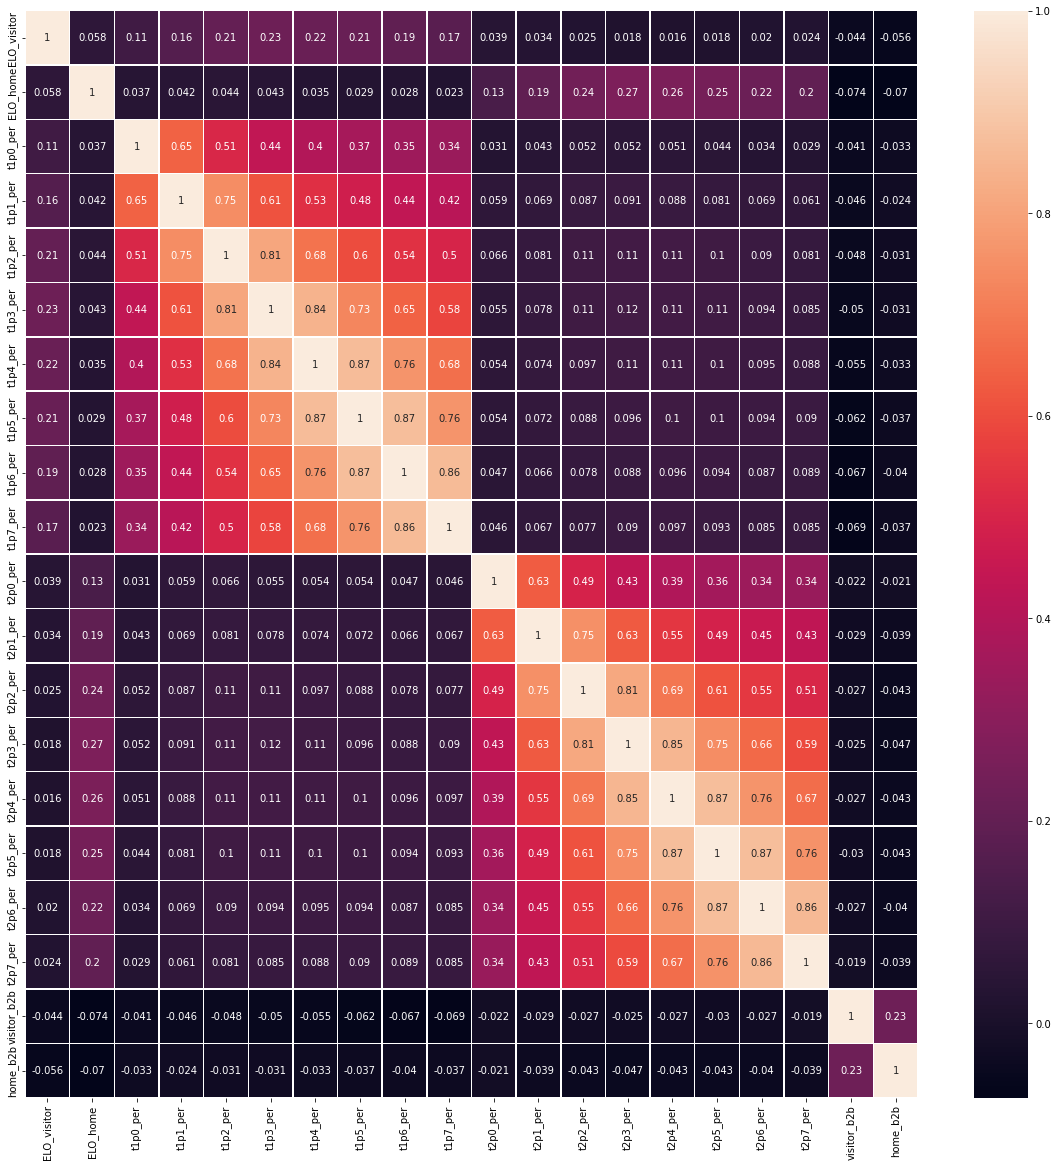

In [18]:
corr_matrix = train_features.corr()

#Using heatmap to visualize the correlation matrix
fig, ax = plt.subplots(figsize=(20,20)) 
sn.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)

In [19]:
model = LogisticRegression(random_state=0)
model.fit(train_features, Y)

LogisticRegression(random_state=0)

In [20]:
test_features = test_df.loc[:, 'ELO_visitor':'home_b2b']
test_Y = test_df.loc[:, 'Y']

In [21]:
model_pipeline = Pipeline(
    [
        ('model', LogisticRegression(random_state=0))
    ]
)

In [22]:
model_pipeline.fit(train_features, Y)

Pipeline(steps=[('model', LogisticRegression(random_state=0))])

In [23]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.6338028169014085

In [24]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.4675324675324675

In [25]:
prec, rec, thresholds = precision_recall_curve(y_true=test_Y, probas_pred=model_pipeline.predict_proba(test_features)[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


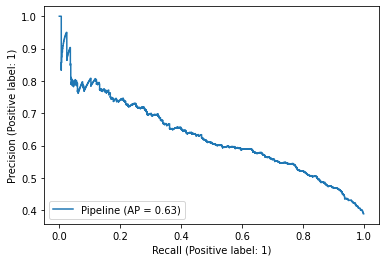

In [26]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_features, y=test_Y)

In [27]:
np.where(prec > 0.75)

(array([1805, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816,
        1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827,
        1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838,
        1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849,
        1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
        1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
        1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
        1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
        1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
        1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
        1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
        1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
        1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
        1949, 1950, 1951, 1952, 1953, 

In [28]:
thresholds[1805]

0.6818865680882803

In [29]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1805])

0.75

In [30]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1805])

0.16753246753246753

In [31]:
grid_pipeline = Pipeline(
    [
        ('model', 
          GridSearchCV(
            LogisticRegression(random_state=0, max_iter=5000),
            param_grid={'C': [0.1, 1, 10.]},
            cv=3,
            verbose=4
            )
        )
    ]
)

In [32]:
grid_pipeline.fit(train_features, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.673 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.679 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.671 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.674 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.679 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.670 total time=   0.2s
[CV 1/3] END ............................C=10.0;, score=0.673 total time=   0.3s
[CV 2/3] END ............................C=10.0;, score=0.678 total time=   0.3s
[CV 3/3] END ............................C=10.0;, score=0.669 total time=   0.3s


Pipeline(steps=[('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(max_iter=5000,
                                                           random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [76]:
def to_get_results(df_input, model_input, comment):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_validate_features = df_input.loc[:, 'ELO_visitor':'home_b2b']
  df_validate_y = df_input.loc[:, 'Y']

  # active_thresholds = thresholds[1805]
  # active_thresholds = 0.5
  # predictions = model_pipeline.predict_proba(df_validate_features)[:, 1] > active_thresholds
  # predictions = model_pipeline.predict(df_validate_features)
  predictions = model_input.predict(df_validate_features)

  real_results = df_validate_y.tolist()

  bet_size = 100
  total_bet = 0
  total_win = 0

  step = []
  money = []
  current = 0

  good_precision = 0

  max_donw_streak = 0
  peak_money = 0
  current_down_streak = 0

  for i, prediction in enumerate(predictions):
    visitor_odd = df_input.loc[i, 'visitor_odd']
    home_odd = df_input.loc[i, 'home_odd']

    # print(f'step {i}; date: {df_input.loc[i, "date"]}; visitor_score: {df_input.loc[i, "visitor_score"]}, home_score: {df_input.loc[i, "home_score"]}, visitor_odd: {float(visitor_odd)}, home_odd: {float(home_odd)}, real: {real_results[i]}, {bool(real_results[i])}, prediction: {bool(prediction)}')

    if bool(real_results[i]) == bool(prediction):
      if bool(prediction) is True:
        total_win += bet_size * float(visitor_odd)
        current += bet_size * float(visitor_odd)
        # print(f'WIN: {bet_size * float(visitor_odd)}')
      else:
        total_win += bet_size * float(home_odd)
        current += bet_size * float(home_odd)
        # print(f'WIN: {bet_size * float(home_odd)}')
      good_precision += 1

    # print('-----')
    
    total_bet += bet_size
    current -= bet_size
    money.append(current)
    step.append(i)
    
    if current < peak_money:
      current_down_streak += 1
    else: 
      current_down_streak = 0
    max_donw_streak = max(max_donw_streak, current_down_streak)
    peak_money = max(peak_money, current)

  print(f'ROI = {round(total_win/total_bet, 3)}, comment = {comment}, accuracy = {round(good_precision / len(df_validate_y), 3)}, count_bets = {total_bet/bet_size}, wins = {round(total_win, 3)}, bets = {round(total_bet, 3)}, cash = {round(total_win - total_bet, 3)}, max_down_streak = {max_donw_streak}')

  plt.plot(step, money, label=comment)

  plt.legend()
  plt.xlabel('step')
  plt.ylabel('money')


In [ ]:
# save csv
df_full_validate.to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds.csv', sep='\t', encoding='utf-8')

In [ ]:
# save csv
df_full_validate[df_full_validate['season'] > 2016].to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds_2017.csv', sep='\t', encoding='utf-8')

In [62]:
# decision trees, 2017-2022 seasons
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_features, Y)

ROI = 0.961, comment = 2017-2022, LR, accuracy = 0.643, count_bets = 7368.0, wins = 708182.0, bets = 736800, cash = -28618.0, max_down_streak = 7274
ROI = 0.981, comment = 2017-2022, DT, accuracy = 0.587, count_bets = 7368.0, wins = 722987.0, bets = 736800, cash = -13813.0, max_down_streak = 7289


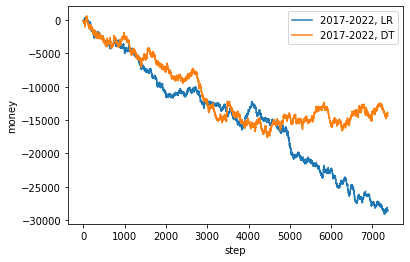

In [77]:
# linear regression, decision tress 2017-2022 seasons
to_get_results(df_full_validate, model_pipeline, '2017-2022, LR')
to_get_results(df_full_validate, clf, '2017-2022, DT')

ROI = 0.957, comment = 2017, accuracy = 0.646, count_bets = 1270.0, wins = 121544.0, bets = 127000, cash = -5456.0, max_down_streak = 1176
ROI = 0.963, comment = 2018, accuracy = 0.656, count_bets = 1285.0, wins = 123782.0, bets = 128500, cash = -4718.0, max_down_streak = 1276
ROI = 0.955, comment = 2019, accuracy = 0.655, count_bets = 1283.0, wins = 122473.0, bets = 128300, cash = -5827.0, max_down_streak = 1124
ROI = 0.992, comment = 2020, accuracy = 0.653, count_bets = 1113.0, wins = 110459.0, bets = 111300, cash = -841.0, max_down_streak = 859
ROI = 0.942, comment = 2021, accuracy = 0.605, count_bets = 1139.0, wins = 107332.0, bets = 113900, cash = -6568.0, max_down_streak = 1138
ROI = 0.959, comment = 2022, accuracy = 0.639, count_bets = 1278.0, wins = 122592.0, bets = 127800, cash = -5208.0, max_down_streak = 1271


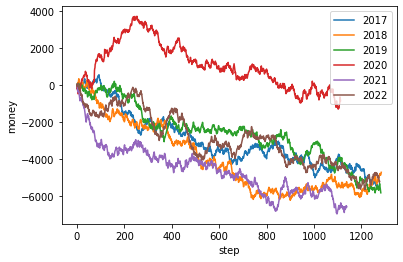

In [64]:
# linear regression
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, model_pipeline, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, model_pipeline, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, model_pipeline, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, model_pipeline, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, model_pipeline, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, model_pipeline, '2022')

ROI = 0.959, comment = 2017, accuracy = 0.565, count_bets = 1270.0, wins = 121809.0, bets = 127000, cash = -5191.0, max_down_streak = 1191
ROI = 0.975, comment = 2018, accuracy = 0.595, count_bets = 1285.0, wins = 125227.0, bets = 128500, cash = -3273.0, max_down_streak = 972
ROI = 0.947, comment = 2019, accuracy = 0.569, count_bets = 1283.0, wins = 121504.0, bets = 128300, cash = -6796.0, max_down_streak = 1178
ROI = 1.007, comment = 2020, accuracy = 0.607, count_bets = 1113.0, wins = 112087.0, bets = 111300, cash = 787.0, max_down_streak = 575
ROI = 0.997, comment = 2021, accuracy = 0.585, count_bets = 1139.0, wins = 113535.0, bets = 113900, cash = -365.0, max_down_streak = 603
ROI = 1.008, comment = 2022, accuracy = 0.603, count_bets = 1278.0, wins = 128825.0, bets = 127800, cash = 1025.0, max_down_streak = 390


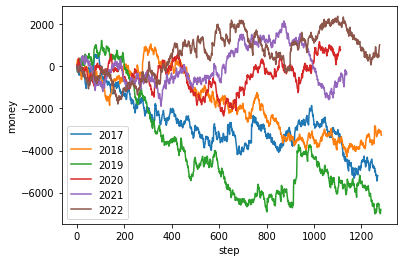

In [65]:
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, clf, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, clf, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, clf, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, clf, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, clf, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, clf, '2022')

ROI = 0.938, comment = oct, accuracy = 0.627, count_bets = 338.0, wins = 31719.0, bets = 33800, cash = -2081.0, max_down_streak = 301
ROI = 0.977, comment = nov, accuracy = 0.649, count_bets = 1093.0, wins = 106746.0, bets = 109300, cash = -2554.0, max_down_streak = 1027
ROI = 0.922, comment = dec, accuracy = 0.616, count_bets = 1146.0, wins = 105640.0, bets = 114600, cash = -8960.0, max_down_streak = 1033
ROI = 0.965, comment = jan, accuracy = 0.645, count_bets = 1323.0, wins = 127726.0, bets = 132300, cash = -4574.0, max_down_streak = 1323
ROI = 0.973, comment = feb, accuracy = 0.656, count_bets = 1004.0, wins = 97670.0, bets = 100400, cash = -2730.0, max_down_streak = 774
ROI = 0.978, comment = mar, accuracy = 0.666, count_bets = 1187.0, wins = 116127.0, bets = 118700, cash = -2573.0, max_down_streak = 772
ROI = 0.95, comment = apr, accuracy = 0.639, count_bets = 756.0, wins = 71783.0, bets = 75600, cash = -3817.0, max_down_streak = 753
ROI = 0.97, comment = may, accuracy = 0.655, c

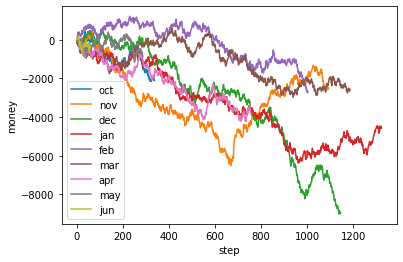

In [66]:
# linear regression by months
season = df_full_validate[df_full_validate['month'] == 'oct']
to_get_results(season, model_pipeline, 'oct')

season = df_full_validate[df_full_validate['month'] == 'nov']
to_get_results(season, model_pipeline, 'nov')

season = df_full_validate[df_full_validate['month'] == 'dec']
to_get_results(season, model_pipeline, 'dec')

season = df_full_validate[df_full_validate['month'] == 'jan']
to_get_results(season, model_pipeline, 'jan')

season = df_full_validate[df_full_validate['month'] == 'feb']
to_get_results(season, model_pipeline, 'feb')

season = df_full_validate[df_full_validate['month'] == 'mar']
to_get_results(season, model_pipeline, 'mar')

season = df_full_validate[df_full_validate['month'] == 'apr']
to_get_results(season, model_pipeline, 'apr')

season = df_full_validate[df_full_validate['month'] == 'may']
to_get_results(season, model_pipeline, 'may')

season = df_full_validate[df_full_validate['month'] == 'jun']
to_get_results(season, model_pipeline, 'jun')

ROI = 0.969, comment = Boston Celtics, accuracy = 0.653, count_bets = 277.0, wins = 26843.0, bets = 27700, cash = -857.0, max_down_streak = 148
ROI = 0.981, comment = Chicago, accuracy = 0.623, count_bets = 231.0, wins = 22658.0, bets = 23100, cash = -442.0, max_down_streak = 224
ROI = 0.95, comment = Golden State, accuracy = 0.735, count_bets = 268.0, wins = 25454.0, bets = 26800, cash = -1346.0, max_down_streak = 218
ROI = 0.893, comment = Los Angeles Lakers, accuracy = 0.608, count_bets = 245.0, wins = 21873.0, bets = 24500, cash = -2627.0, max_down_streak = 240
ROI = 1.015, comment = New York, accuracy = 0.635, count_bets = 233.0, wins = 23638.0, bets = 23300, cash = 338.0, max_down_streak = 105
ROI = 0.95, comment = Sacramento, accuracy = 0.595, count_bets = 227.0, wins = 21557.0, bets = 22700, cash = -1143.0, max_down_streak = 116


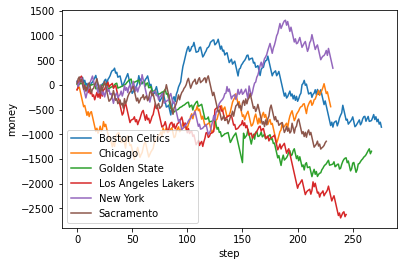

In [67]:
# linear regression by teams (home)
# franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 35: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}
season = df_full_validate[df_full_validate['id_home'] == 2]
to_get_results(season, model_pipeline, 'Boston Celtics')

season = df_full_validate[df_full_validate['id_home'] == 5]
to_get_results(season, model_pipeline, 'Chicago')

season = df_full_validate[df_full_validate['id_home'] == 10]
to_get_results(season, model_pipeline, 'Golden State')

season = df_full_validate[df_full_validate['id_home'] == 14]
to_get_results(season, model_pipeline, 'Los Angeles Lakers')

season = df_full_validate[df_full_validate['id_home'] == 20]
to_get_results(season, model_pipeline, 'New York')

season = df_full_validate[df_full_validate['id_home'] == 26]
to_get_results(season, model_pipeline, 'Sacramento')

ROI = 0.948, comment = Boston Celtics, accuracy = 0.593, count_bets = 273.0, wins = 25892.0, bets = 27300, cash = -1408.0, max_down_streak = 270
ROI = 0.899, comment = Chicago, accuracy = 0.634, count_bets = 232.0, wins = 20847.0, bets = 23200, cash = -2353.0, max_down_streak = 228
ROI = 0.983, comment = Golden State, accuracy = 0.667, count_bets = 264.0, wins = 25954.0, bets = 26400, cash = -446.0, max_down_streak = 173
ROI = 0.926, comment = Los Angeles Lakers, accuracy = 0.619, count_bets = 244.0, wins = 22591.0, bets = 24400, cash = -1809.0, max_down_streak = 216
ROI = 0.945, comment = New York, accuracy = 0.687, count_bets = 230.0, wins = 21734.0, bets = 23000, cash = -1266.0, max_down_streak = 224
ROI = 0.934, comment = Sacramento, accuracy = 0.645, count_bets = 231.0, wins = 21583.0, bets = 23100, cash = -1517.0, max_down_streak = 220


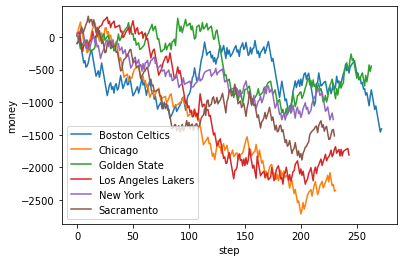

In [68]:
# linear regression by teams (away)
season = df_full_validate[df_full_validate['id_visitor'] == 2]
to_get_results(season, model_pipeline, 'Boston Celtics')

season = df_full_validate[df_full_validate['id_visitor'] == 5]
to_get_results(season, model_pipeline, 'Chicago')

season = df_full_validate[df_full_validate['id_visitor'] == 10]
to_get_results(season, model_pipeline, 'Golden State')

season = df_full_validate[df_full_validate['id_visitor'] == 14]
to_get_results(season, model_pipeline, 'Los Angeles Lakers')

season = df_full_validate[df_full_validate['id_visitor'] == 20]
to_get_results(season, model_pipeline, 'New York')

season = df_full_validate[df_full_validate['id_visitor'] == 26]
to_get_results(season, model_pipeline, 'Sacramento')


ROI = 1.084, comment = oct 2020, accuracy = 0.667, count_bets = 51.0, wins = 5530.0, bets = 5100, cash = 430.0, max_down_streak = 16
ROI = 1.151, comment = nov 2020, accuracy = 0.74, count_bets = 215.0, wins = 24739.0, bets = 21500, cash = 3239.0, max_down_streak = 28
ROI = 0.908, comment = dec 2020, accuracy = 0.624, count_bets = 218.0, wins = 19786.0, bets = 21800, cash = -2014.0, max_down_streak = 218
ROI = 0.949, comment = jan 2020, accuracy = 0.643, count_bets = 221.0, wins = 20969.0, bets = 22100, cash = -1131.0, max_down_streak = 221
ROI = 0.967, comment = feb 2020, accuracy = 0.681, count_bets = 163.0, wins = 15768.0, bets = 16300, cash = -532.0, max_down_streak = 123


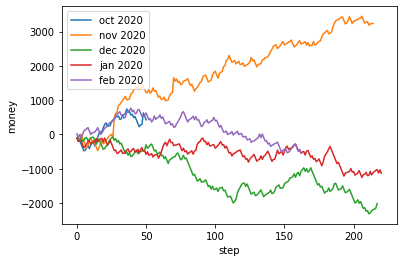

In [69]:
# linear regression by months
season = df_full_validate[(df_full_validate['month'] == 'oct') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'oct 2020')

season = df_full_validate[(df_full_validate['month'] == 'nov') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'nov 2020')

season = df_full_validate[(df_full_validate['month'] == 'dec') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'dec 2020')

season = df_full_validate[(df_full_validate['month'] == 'jan') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'jan 2020')

season = df_full_validate[(df_full_validate['month'] == 'feb') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'feb 2020')

ROI = 0.769, comment = mar 2019, accuracy = 0.52, count_bets = 25.0, wins = 1923.0, bets = 2500, cash = -577.0, max_down_streak = 25


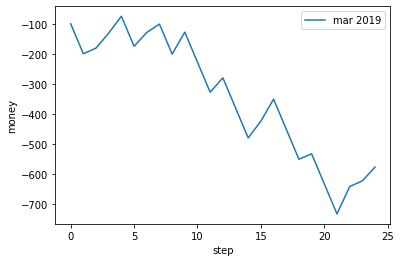

In [70]:
season = df_full_validate[(df_full_validate['month'] == 'mar') & (df_full_validate['season'] == 2019)].head(25)
to_get_results(season, model_pipeline, 'mar 2019')